# Model-free Pulse Gate Calibration using Reinforcement Learning

In this notebook, we adjust the definition of the gate to be a custom pulse sequence to be simulated by Qiskit-Dynamics package.

This notebook combines previously introduced modules of Qiskit and Tensorflow, combined to the usage of Qiskit-Dynamics to handle a pulse level simulation.

In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment, get_solver_and_freq_from_backend
from helper_functions import select_optimizer, generate_model, custom_pulse_schedule

# Qiskit imports for building RL environment (circuit level)
from qiskit import pulse, transpile
from qiskit.providers.options import Options
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta
from qiskit.providers import QubitProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_dynamics import DynamicsBackend
from qiskit_dynamics.array import Array
from qiskit.circuit import ParameterVector, Parameter, ParameterExpression, QuantumCircuit, Gate
from qiskit.extensions import CXGate, XGate, SXGate, RZGate
from qiskit.opflow import H, I, X, S
from qiskit_ibm_provider import IBMBackend, IBMProvider

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

from tf_agents.specs import array_spec, tensor_spec

# Additional imports
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Optional
# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend

Array.set_default_backend('jax')


In [2]:
# Pulse gate ansatz

def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :return:
    """
    # qc.num_qubits
    global n_actions, fake_backend, backend, qubit_tgt_register, target

    # x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit_tgt_register,)).instructions[0][1].pulse
    params = ParameterVector('theta', n_actions)

    # original_calibration = backend.instruction_schedule_map.get(target["name"])

    parametrized_gate = Gate(f"custom_{target['gate'].name}", 1, params=[params[0]])
    default_schedule = fake_backend.defaults().instruction_schedule_map.get(target["gate"].name, qubit_tgt_register)
    parametrized_schedule = custom_pulse_schedule(backend=backend, target=target, qubit_tgt_register=qubit_tgt_register,
                                                  params=params, default_schedule=default_schedule)
    qc.add_calibration(parametrized_gate, qubit_tgt_register, parametrized_schedule)
    qc.append(parametrized_gate, qubit_tgt_register)

# Defining the QuantumEnvironment

We provide below the details of our custom Quantum Processing Unit (QPU) we are controlling.

In [3]:
qubit_tgt_register = [0]  # Choose which qubits of the QPU you want to address 
n_qubits = len(qubit_tgt_register)  # Set number of qubits to set the simulation details
sampling_Paulis = 10
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
n_actions = 1  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)

estimator_options = {'resilience_level': 0}

Choose below which IBM Backend to use. As we are dealing with pulse level implementation, we can either simulate a backend using QiskitDynamics, or use a real backend that supports OpenPulse features.

In [4]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend
"""
backend_name = 'ibm_perth'
#provider = IBMProvider()
#service = QiskitRuntimeService(channel='ibm_quantum')

#runtime_backend = service.get_backend(backend_name)
#real_backend = provider.get_backend(backend_name)


Fake backend initialization:
Run this cell only if intending to use a a simulation backend.
Here we choose to get the Hamiltonian details of our simulated backend from an IBM FakeBackend,
it could also be a user defined custom Hamiltonian/Linblad that could be used to feed the Qiskit DynamicsBackend object.
cf. QiskitDynamics documentation


In [5]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
service = None
fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
control_channel_map = {}
control_channel_map_backend = {
    **{qubits: fake_backend.configuration().control_channels[qubits][0].index for qubits in fake_backend.configuration().control_channels}}
for qubits in control_channel_map_backend:
    if qubits[0] in qubit_tgt_register and qubits[1] in qubit_tgt_register:
        control_channel_map[qubits] = control_channel_map_backend[qubits]


In [6]:
dynamics_options = {'seed_simulator': 5000, #"configuration": fake_backend.configuration(),
                    'control_channel_map': control_channel_map,
                    # Control channels to play CR tones, should match connectivity of device
                    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
                    }
dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=qubit_tgt_register, **dynamics_options)

target = dynamics_backend.target
target.qubit_properties = fake_backend_v2.qubit_properties(qubit_tgt_register)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=qubit_tgt_register,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None
)

In [7]:
# Choose backend among the set defined above: {runtime_backend, real_backend, dynamics_backend}
backend = dynamics_backend

In [8]:
# Define target gate
X_tgt = {
    "target_type": 'gate',
    "gate": XGate("X"),
    "register": qubit_tgt_register,
    "input_states": [
        {"name": '|0>',
         "circuit": I},

        {"name": '|1>',
         "circuit": X},

        {"name": '|+>',
         "circuit": H},
        {"name": '|->',
         "circuit": H @ X},
    ]

}

target = X_tgt

In [9]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = {
    "backend": backend,
    "parametrized_circuit": apply_parametrized_circuit,
    "estimator_options": estimator_options,
    "service": service,
    "target_register": qubit_tgt_register,
    "channel_freq": channel_freq,
    "solver": solver
}

action_spec = tensor_spec.BoundedTensorSpec(shape=(n_actions,), dtype=tf.float32, minimum=-1., maximum=1.)
observation_spec = array_spec.ArraySpec(shape=(time_steps,), dtype=np.int32)

Running the box below declares the QuantumEnvironment instance.

If chosen backend is a simulated backend (through Qiskit Dynamics), this declaration launches a series of single qubit gate calibrations (to calibrate X and SX gate). The reason for this is that the Estimator primitive, which enables the easy calculation of Pauli expectation values, needs to append gates for doing Pauli basis rotations (SX and Rz gate).

In [10]:
%%time
q_env = QuantumEnvironment(n_qubits=n_qubits, target=target, abstraction_level="pulse",
                           action_spec=action_spec, observation_spec=observation_spec,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.5)

Starting initial single qubit gates calibrations...
Backend Initial Target
Number of qubits: 1
Instructions:
	measure
		(0,):
			With pulse schedule calibration
	rz
		(0,):
			Error Rate: 0.0
			With pulse schedule calibration
	id
		(0,):
			Error Rate: 0.0
			With pulse schedule calibration
	x
		(0,)
	sx
		(0,)

Starting Rabi experiments...
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All calibrations are done
Calibration <qiskit_experiments.calibration_management.calibrations.Calibrations object at 0x7ff04f03db20>
Updated Target
Number of qubits: 1
Instructions:
	measure
		(0,):
			With pulse schedule calibration
	rz
		(0,):
			Error Rate: 0.0
			With pulse schedule calibration
	id
		(0,):
			Error Rate: 0.0
			With pulse schedule calibration
	x
		(0,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.01
			With pulse schedule calibration
	sx
		(0,):
			Duration: 3.55

# Defining the RL agent: PPO

In [11]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
%time
# Hyperparameters for the agent
n_epochs = 200  # Number of epochs
batchsize = 50  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"
eta = 0.001  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.1  # Parameter for clipping value (PPO)
grad_clip = 0.01
critic_loss_coeff = 0.5
optimizer = select_optimizer(lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2)
sigma_eps = 1e-3  # for numerical stability

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


In [12]:
"""
-----------------------------------------------------------------------------------------------------
Policy parameters
-----------------------------------------------------------------------------------------------------
"""
# Policy parameters
N_in = n_qubits + 1  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [82, 82]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros((1, N_in))  # Here no feedback involved, so measurement sequence is always the same

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 82)           246         input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 82)           6806        hidden_0[0][0]                   
__________________________________________________________________________________________________
mean_vec (Dense)                (None, 1)            83          hidden_1[0][0]                   
______________________________________________________________________________________________

In [13]:
# Plotting tools
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 20
%matplotlib inline

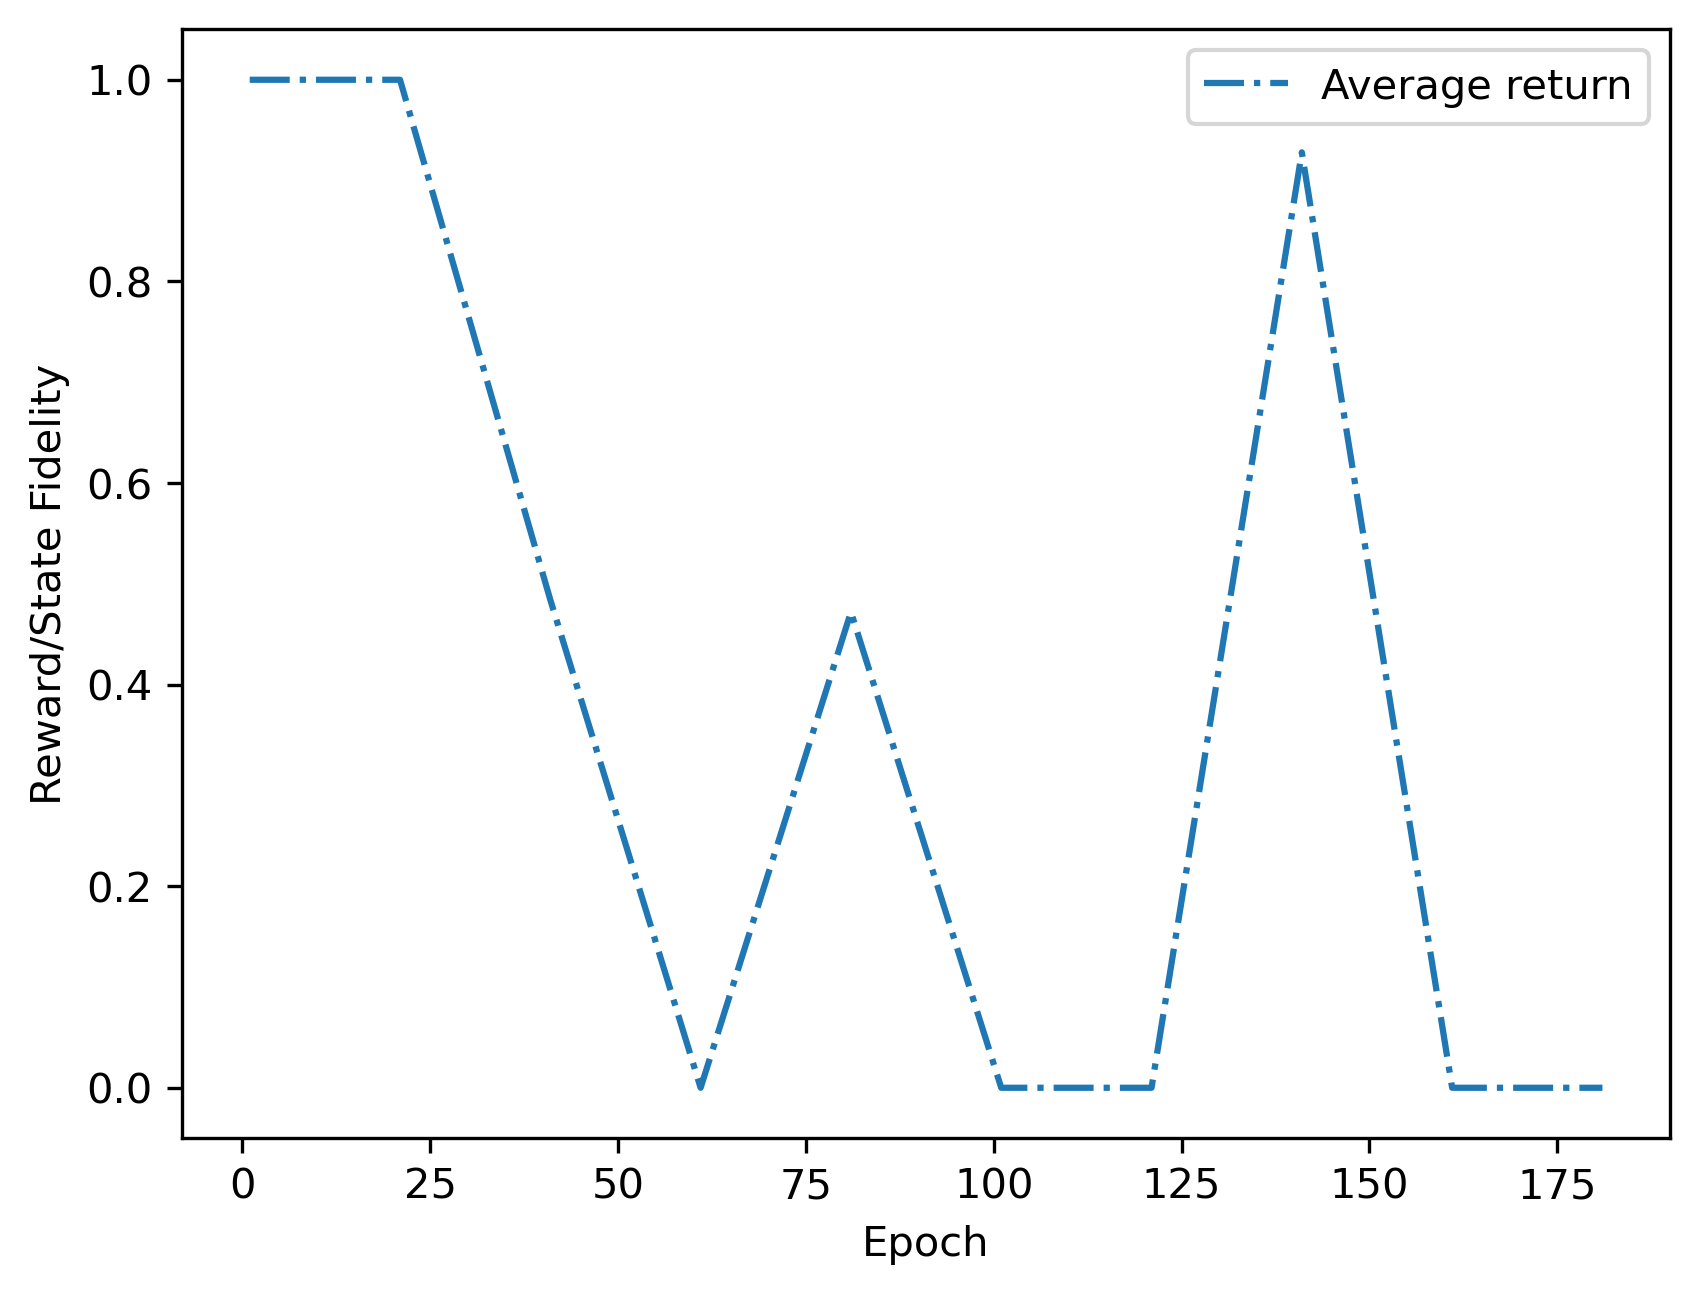

 90%|█████████████████████████████████████    | 181/200 [58:43<12:01, 37.99s/it]

Maximum return reached so far: 1.0 at Epoch 0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 91%|█████████████████████████████████████▎   | 182/200 [59:17<11:03, 36.86s/it]

Job done

 Epoch 181
Average reward 0.99
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 92%|█████████████████████████████████████▌   | 183/200 [59:54<10:27, 36.93s/it]

Job done

 Epoch 182
Average reward 0.9940000000000001
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 92%|███████████████████████████████████▉   | 184/200 [1:00:32<09:52, 37.04s/it]

Job done

 Epoch 183
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 92%|████████████████████████████████████   | 185/200 [1:01:09<09:16, 37.10s/it]

Job done

 Epoch 184
Average reward 0.992
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 93%|████████████████████████████████████▎  | 186/200 [1:01:47<08:42, 37.32s/it]

Job done

 Epoch 185
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 94%|████████████████████████████████████▍  | 187/200 [1:02:21<07:54, 36.52s/it]

Job done

 Epoch 186
Average reward 0.99
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 94%|████████████████████████████████████▋  | 188/200 [1:03:00<07:24, 37.05s/it]

Job done

 Epoch 187
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 94%|████████████████████████████████████▊  | 189/200 [1:03:38<06:51, 37.45s/it]

Job done

 Epoch 188
Average reward 1.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 95%|█████████████████████████████████████  | 190/200 [1:04:16<06:15, 37.52s/it]

Job done

 Epoch 189
Average reward 1.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 96%|█████████████████████████████████████▏ | 191/200 [1:04:55<05:42, 38.04s/it]

Job done

 Epoch 190
Average reward 0.9840000000000001
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 96%|█████████████████████████████████████▍ | 192/200 [1:05:33<05:03, 37.93s/it]

Job done

 Epoch 191
Average reward 0.97
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 96%|█████████████████████████████████████▋ | 193/200 [1:06:15<04:34, 39.26s/it]

Job done

 Epoch 192
Average reward 0.9940000000000001
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 97%|█████████████████████████████████████▊ | 194/200 [1:06:57<03:59, 39.92s/it]

Job done

 Epoch 193
Average reward 0.982
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 98%|██████████████████████████████████████ | 195/200 [1:07:35<03:17, 39.46s/it]

Job done

 Epoch 194
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 98%|██████████████████████████████████████▏| 196/200 [1:08:15<02:38, 39.64s/it]

Job done

 Epoch 195
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 98%|██████████████████████████████████████▍| 197/200 [1:08:56<02:00, 40.13s/it]

Job done

 Epoch 196
Average reward 0.9760000000000001
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


 99%|██████████████████████████████████████▌| 198/200 [1:09:33<01:18, 39.25s/it]

Job done

 Epoch 197
Average reward 0.9800000000000001
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


100%|██████████████████████████████████████▊| 199/200 [1:10:13<00:39, 39.47s/it]

Job done

 Epoch 198
Average reward 0.0
Calibrations of quantum circuit {'custom_x': {((0,), (ParameterVectorElement(theta[0]),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.0205387662332952, amp=theta[0], angle=0.0), DriveChannel(0)), name="param_schedule", transform=AlignLeft())}}
Sending job to Estimator...


100%|███████████████████████████████████████| 200/200 [1:10:56<00:00, 21.28s/it]

Job done

 Epoch 199
Average reward 1.0


In [14]:
"""
-----------------------------------------------------------------------------------------------------
Training loop
-----------------------------------------------------------------------------------------------------
"""
%time
mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(loc=mu_old, scale_diag=sigma_old,
                                         validate_args=True, allow_nan_stats=False)

    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(init_msmt, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(loc=mu, scale_diag=sigma,
                                                validate_args=True, allow_nan_stats=False)

        action_vector = tf.stop_gradient(tf.clip_by_value(Policy_distrib.sample(batchsize), 0, 1.))

        # Adjust the action vector according to params physical significance

        reward = q_env.perform_action(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-6)
            actor_loss = - tf.reduce_mean(tf.minimum(advantage * ratio,
                                                     advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)))
        else:  # REINFORCE algorithm
            actor_loss = - tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage ** 2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    
    avg_return[i] = np.mean(q_env.reward_history, axis =1)[i]
    # fidelities[i] = q_env.avg_fidelity_history[i]
    print('\n Epoch', i)
    print("Average reward", np.mean(q_env.reward_history[i]))
    
    if i%visualization_steps == 0:
        clear_output(wait=True) # for animation
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs, 20),avg_return[0:-1:visualization_steps], '-.', label='Average return')
       # ax.plot(np.arange(1, n_epochs, 20),fidelities[0:-1:visualization_steps], label='Average Gate Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Reward/State Fidelity")
        ax.legend()
        plt.show()
        # print("Maximum fidelity reached so far:", np.max(fidelities), "at Epoch", np.argmax(fidelities))
        print("Maximum return reached so far:", np.max(avg_return), "at Epoch", np.argmax(avg_return))
        # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))